# SMS класифікація спаму

In [209]:
# !pip install scikit-learn
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib

In [210]:
import warnings as wr
import pandas as pd
wr.filterwarnings("ignore")
import seaborn as sns

sms=pd.read_csv("./preprocessed_sms.csv", encoding='latin-1')
print("Shape: ", sms.shape)
sms.head()

Shape:  (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [211]:
data = sms
X = data.message
y = data.label

In [212]:
# ділимо датасет на навчальний та тестувальний
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [213]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

In [214]:
# створюємо словник, будуємо DTM
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<4179x7545 sparse matrix of type '<class 'numpy.int64'>'
	with 55803 stored elements in Compressed Sparse Row format>

In [215]:
# будуємо DTM на тестових даних
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7545 sparse matrix of type '<class 'numpy.int64'>'
	with 16725 stored elements in Compressed Sparse Row format>

In [216]:
# кількість колонок не змінюється, оскільки для тестових даних використовується той самий словник, що і для навчальних 

# MultinomialNB

In [217]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [218]:
y_pred_class = nb.predict(X_test_dtm)

In [219]:
# точність
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9899497487437185

<Axes: >

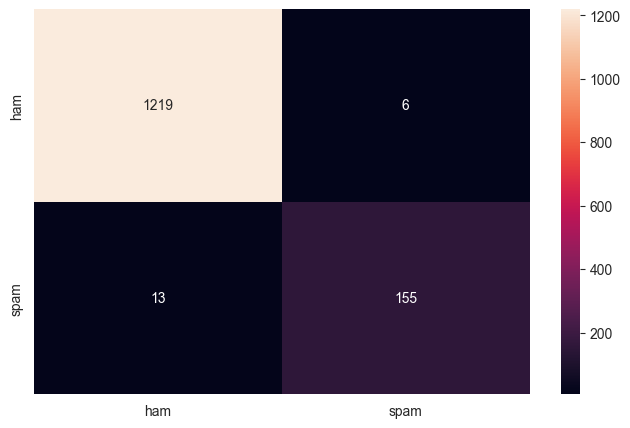

In [237]:
# матриця невідповідностей
import matplotlib.pyplot as plt
cf_matrix=metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,5))
sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])

In [221]:
# false positives
X_test[(y_pred_class==1) & (y_test==0)]

Series([], Name: message, dtype: object)

In [222]:
# false negatives
X_test[(y_pred_class==0) & (y_test==1)]

Series([], Name: message, dtype: object)

In [223]:
# площа під кривою
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9751846452866861

# LogisticRegression

In [224]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)

LogisticRegression()

In [225]:
y_pred_class = logreg.predict(X_test_dtm)

In [226]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9842067480258435

In [227]:
# площа під кривою
metrics.roc_auc_score(y_test, y_pred_prob)

0.9751846452866861

In [228]:
# remove English stop words
vect1 = CountVectorizer(stop_words='english')
X_train_1 = vect1.fit_transform(X_train)
X_train_1

<4179x7285 sparse matrix of type '<class 'numpy.int64'>'
	with 32792 stored elements in Compressed Sparse Row format>

In [229]:
# включає 1-грами and 2-грами
# "Happy", "Not Happy", "Very Happy"
vect2 = CountVectorizer(ngram_range=(1, 2))

X_train_2 = vect2.fit_transform(X_train)

X_train_2

<4179x41300 sparse matrix of type '<class 'numpy.int64'>'
	with 111703 stored elements in Compressed Sparse Row format>

In [230]:
# ігнорувати терміни, які зустрічаються в більш ніж 50% документів
vect3 = CountVectorizer(max_df=0.5)

X_train_3 = vect3.fit_transform(X_train)

X_train_3

<4179x7545 sparse matrix of type '<class 'numpy.int64'>'
	with 55803 stored elements in Compressed Sparse Row format>

In [231]:
# зберігати лише ті терміни, які є принаймні у 2 документах
vect4 = CountVectorizer(min_df=2)

X_train_4 = vect4.fit_transform(X_train)

X_train_4

<4179x3503 sparse matrix of type '<class 'numpy.int64'>'
	with 51761 stored elements in Compressed Sparse Row format>

In [232]:
vect_fine_tuned= CountVectorizer(stop_words='english',ngram_range=(1, 2))

In [233]:
X_train_c = vect_fine_tuned.fit_transform(X_train)
X_test_c = vect_fine_tuned.transform(X_test)

X_train_c

<4179x30133 sparse matrix of type '<class 'numpy.int64'>'
	with 62904 stored elements in Compressed Sparse Row format>

In [234]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_c, y_train)
y_pred_class = nb.predict(X_test_c)

<Axes: >

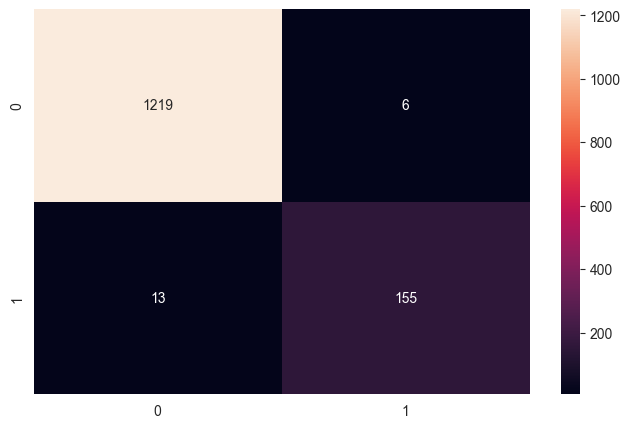

In [235]:
nb_cf_matrix=metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,5))
sns.heatmap(nb_cf_matrix, annot=True, fmt='d')

In [236]:
!pip install gradio
import gradio as gr


def classify_message(message):
    user_input_dtm = vect_fine_tuned.transform([message])
    proba = nb.predict_proba(user_input_dtm)
    return {'Ham': proba[0][0],
            'Spam': proba[0][1]}

interface = gr.Interface(
    fn=classify_message,
    inputs=gr.Textbox(lines=2, placeholder="Enter SMS message..."),
    outputs=gr.Textbox(),
    title="SMS Ham/Spam Classifier",
    description="Enter an SMS message to classify it as Ham or Spam."
)

interface.launch(debug=True, inbrowser=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
